In [163]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [224]:
img = cv2.imread('u2net_pad_dice_tile_reconstructed_new_shuffle_22.png',0)

In [225]:
img = img/255

In [226]:
# print(np.unique(img))

In [227]:
target_thresh = 0.5
print(target_thresh)
img[img >= target_thresh] = 255
img[img < target_thresh] = 0

0.5


In [228]:
img = np.uint8(img)

In [229]:
print(np.unique(img))

[  0 255]


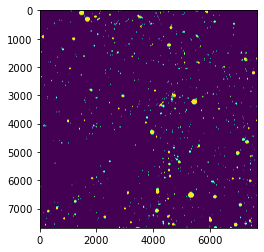

In [230]:
plt.imshow(img)
plt.show()

In [231]:
img.shape

(7680, 7680)

In [232]:
temp_img = np.zeros((img.shape))
contours,hierarchy = cv2.findContours(img,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 23)):
        contour_list.append(contour)
        
cnt = contour_list
print(len(cnt))

bboxes = []
for i in range (len(cnt)):
    (x,y),radius = cv2.minEnclosingCircle(cnt[i])
    # x1,y1,w,h = cv2.boundingRect(cnt[i])
    
    center = (int(x),int(y))
    # radius = (radius)
    if(radius>=7.9 and radius<=138.2):
        bboxes.append([x-radius,y-radius,x+radius,y+radius])
        temp_img = cv2.circle(temp_img,center,int(radius),(255),-1)
    # print('Circle' + str(i) + ': Center =' + str(center) + 'Radius =' + str(radius))

899
788


In [233]:
cv2.imwrite('temp_img.png',temp_img)

True

In [234]:
def non_max_suppression_slow(boxes, overlapThresh):

    if len(boxes) == 0:
        return []

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1  + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        for pos in range(0, last):
            j = idxs[pos]

            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]

            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)	
    return boxes[pick]

In [235]:
bboxes = np.array(bboxes)

In [236]:
nboxes = non_max_suppression_slow(bboxes,0.1)

In [237]:
print(len(bboxes))
print(len(nboxes))

702
679


In [238]:
ntemp_img = np.zeros((img.shape))
coords = []
# bboxes = []
for i in range (len(nboxes)):
    # (x,y),radius = cv2.minEnclosingCircle(cnt[i])
    x1 = nboxes[i,0]
    y1 = nboxes[i,1]
    x2 = nboxes[i,2]
    y2 = nboxes[i,3]
    x = int((x2+x1)//2)
    y = int((y2+y1)//2)
    radius = int((y2-y1)//2)
    center = (int(x),int(y))
    coords.append([x,y,radius])
    ntemp_img = cv2.circle(ntemp_img,center,int(radius),(255),-1)

In [239]:
cv2.imwrite('ntemp_img.png',ntemp_img)

True

In [240]:
# print(coords)

In [241]:
print(len(coords))
longlat_thresh2 = 12
rad_thresh = 1
coords = np.asarray(coords)
i, N = 0, len(coords)
while i < N:
    Long, Lat, Rad = coords.T
    lo, la, r = coords[i]
    minr = np.minimum(r, Rad)

    dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
    dR = abs(Rad - r) / minr
    # print(dR)
    index = (dR < rad_thresh) & (dL < longlat_thresh2)
    if len(np.where(index == True)[0]) > 1:
        # print('r')
        # replace current coord with max match probability coord in
        # duplicate list
        coords_i = coords[np.where(index == True)]
        # corr_i = corr[np.where(index == True)]
        coords_i = sorted(coords_i,key = lambda x:x[2],reverse=True)
        # print(coords_i)
        coords[i] = coords_i[0]
        index[i] = False
        coords = coords[np.where(index == False)]
    N, i = len(coords), i + 1
print(len(coords))

679
663


In [242]:
ntemp_img = np.zeros((img.shape))
for i in range (len(coords)):
    # (x,y),radius = cv2.minEnclosingCircle(cnt[i])
    x = coords[i,0]
    y = coords[i,1]
    radius = coords[i,2]
    center = (int(x),int(y))
    # coords.append([x,y,radius])
    ntemp_img = cv2.circle(ntemp_img,center,int(radius),(255),-1)

In [243]:
cv2.imwrite('ntemp_img_c.png',ntemp_img)

True